# Testing HOTS algorithm on N-MNIST dataset

In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%cd '../'

/Users/joe/Documents/boulot/git/homhots/HOTS


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

from HOTS.ToolsMonitor import GenerateActivationMap, DisplayActivationMap
from HOTS.Event import Event, SimpleAlphabet, LoadNMNIST
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer
from HOTS.ToolsMonitor import (
    DisplayImage,
    DisplaySurface3D,
    DisplaySurface2D,
    DisplayConvergence,
)
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansLagorce import KmeansLagorce
from HOTS.KmeansMaro import KmeansMaro
from HOTS.conv2eve import conv2eve

tau = 1e-2 # -> tau=1ms, si on prend 10 ms on est à 1s pour la dernière couche et les vidéos font 0.3s en moyenne
R = 2
filthr = 2
nbkNN = 3
decay = 'exponential'
nb_cluster = [4, 8, 16]
ImageSize = (34, 34)
DataPath = 'Data/testsetnmnist.p'

Some changes from the initial algorithm are made: 
- random initialisation of the kernels
- normalization of the time-surfaces
- for classification k-NN with k = 3

## Loading random digits from the N-MNIST dataset (2 polarities used)

In [7]:
NbClusteringData = 15
NbTrainingData = 40
NbTestingData = 40
event_tr, event_te, event_cl, label_tr, label_te = LoadNMNIST(
NbTrainingData, NbTestingData, NbClusteringData, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)

[]


## Testing HOTS on N-MNIST

In [8]:
method = 'lagorce'
hom = False
homrun = False

L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
Net = Network([L1, L2, L3])

#timestr = time.strftime("%Y%m%d")
timestr = '20201021'

if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+method+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+method+'.pkl'

print(fname)

if not os.path.isfile(fname):
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(
        event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
    )
    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun = homrun)
    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun = homrun)

    Classif0 = Classifier(
        event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
    )
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)
    SaveObject([ClusterLayer, Classif0], fname)
else:
    ClusterLayer, Classif0 = LoadObject(fname)
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

Records/EXP_03_NMNIST/20201021_hots_0.9ms_lagorce.pkl
battacha:75.0% ### normalized:72.5% ### euclidian:70.0% ### 


[]


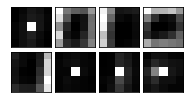

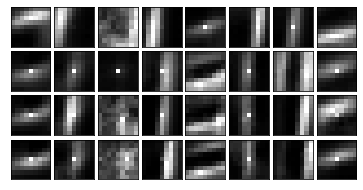

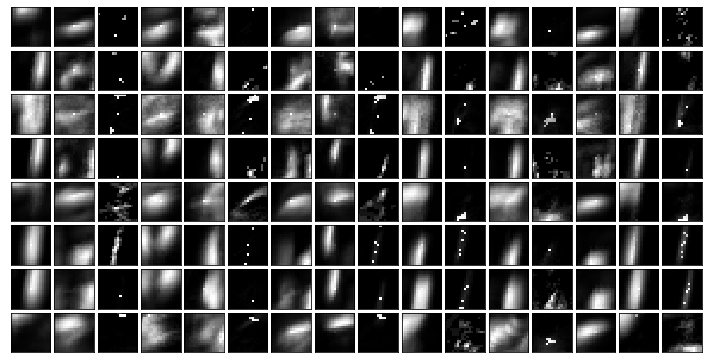

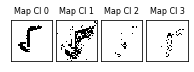

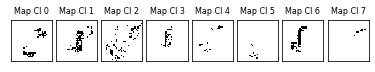

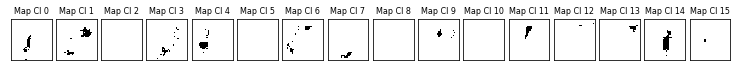

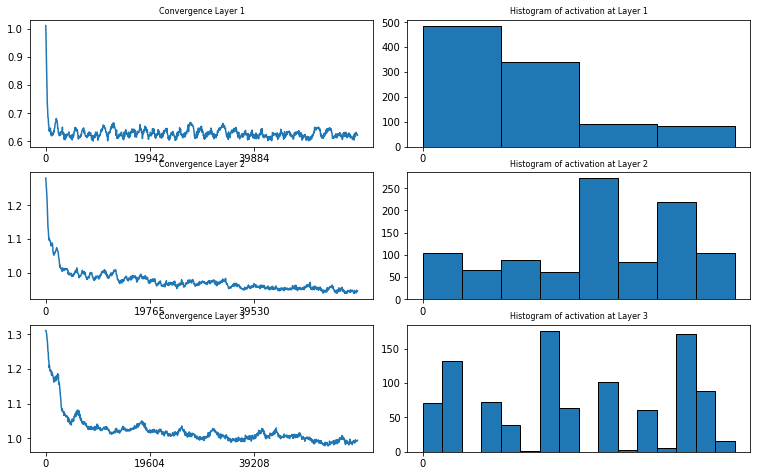

In [9]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)

event_to_show, eventnul, eventnull, labelnul, labelnull = LoadNMNIST(
1, 0, 0, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer, homrun=homrun)
mapL1 = GenerateActivationMap(Net.Layers[0].output, ClusterLayer[0])
DisplayActivationMap(mapL1, scale=2)
mapL2 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[1])
DisplayActivationMap(mapL2, scale=2)
mapL3 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[2])
DisplayActivationMap(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

### Adding Homeostasis

In [10]:
method = 'lagorce'
hom = True
homrun = True

L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
Net = Network([L1, L2, L3])

#timestr = time.strftime("%Y%m%d")
timestr = '20201021'

if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+method+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+method+'.pkl'

print(fname)

if not os.path.isfile(fname):
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(
        event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
    )
    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)

    Classif0 = Classifier(
        event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
    )
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)
    SaveObject([ClusterLayer, Classif0], fname)
else:
    ClusterLayer, Classif0 = LoadObject(fname)
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

Records/EXP_03_NMNIST/20201021_hots_0.9ms_lagorce_homeo.pkl
battacha:55.00000000000001% ### normalized:52.5% ### euclidian:47.5% ### 


[]


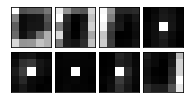

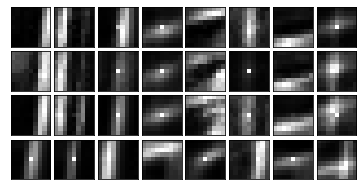

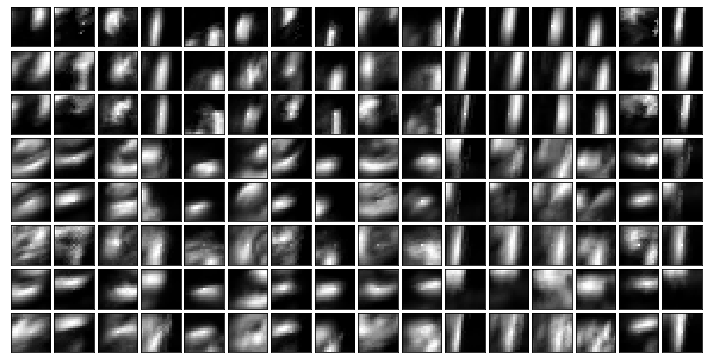

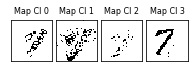

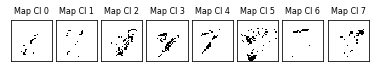

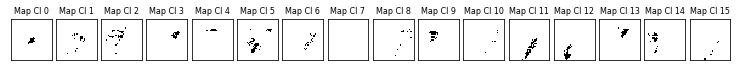

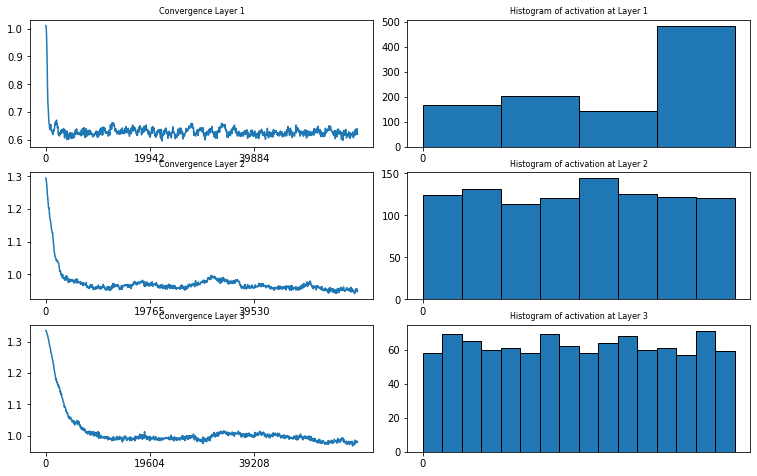

In [11]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)

event_to_show, eventnul, eventnull, label_to_show, labelnull = LoadNMNIST(
1, 0, 0, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer, homrun=homrun)
mapL1 = GenerateActivationMap(Net.Layers[0].output, ClusterLayer[0])
DisplayActivationMap(mapL1, scale=2)
mapL2 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[1])
DisplayActivationMap(mapL2, scale=2)
mapL3 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[2])
DisplayActivationMap(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

## Testing Maro 

In [12]:
method = 'maro'
hom = False
homrun = False

L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
Net = Network([L1, L2, L3])

#timestr = time.strftime("%Y%m%d")
timestr = '20201021'

if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+method+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+method+'.pkl'

print(fname)

if not os.path.isfile(fname):
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(
        event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
    )
    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)

    Classif0 = Classifier(
        event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
    )
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN,to_print=True)
    SaveObject([ClusterLayer, Classif0], fname)
else:
    ClusterLayer, Classif0 = LoadObject(fname)
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN,to_print=True)

Records/EXP_03_NMNIST/20201021_hots_0.9ms_maro.pkl
battacha:52.5% ### normalized:55.00000000000001% ### euclidian:52.5% ### 


[]


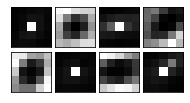

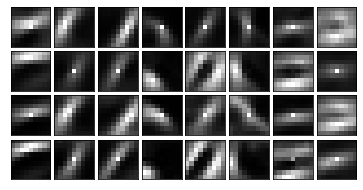

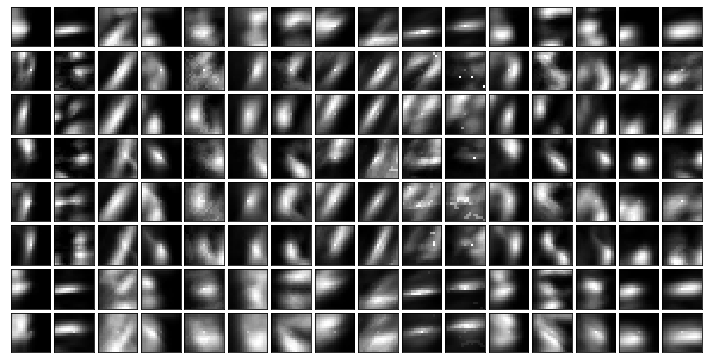

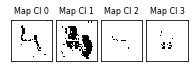

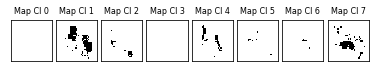

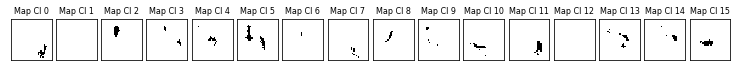

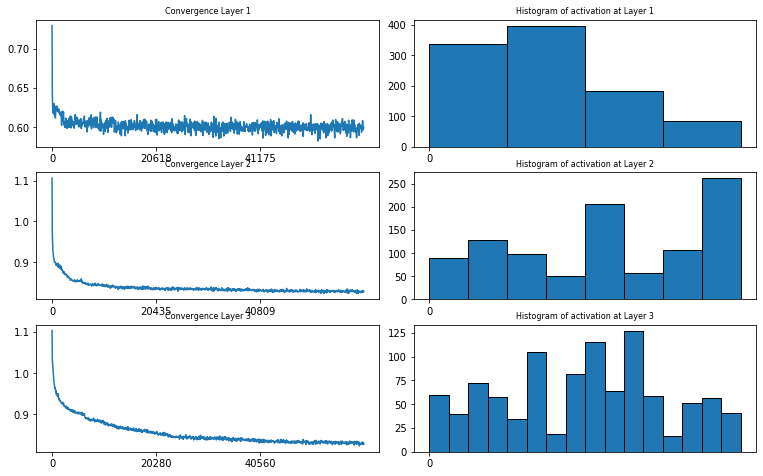

In [13]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)

event_to_show, eventnul, eventnull, labelnul, labelnull = LoadNMNIST(
1, 0, 0, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer, homrun=homrun)
mapL1 = GenerateActivationMap(Net.Layers[0].output, ClusterLayer[0])
DisplayActivationMap(mapL1, scale=2)
mapL2 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[1])
DisplayActivationMap(mapL2, scale=2)
mapL3 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[2])
DisplayActivationMap(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

### Adding Homeostasis

In [ ]:
method = 'maro'
hom = True
homrun = True

L1 = ClusteringLayer(
    tau=tau,
    R=R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
L2 = ClusteringLayer(
    tau=10 * tau,
    R=2 * R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
L3 = ClusteringLayer(
    tau=10 * 10 * tau,
    R=2 * 2 * R,
    verbose=0,
    ThrFilter=filthr,
    LearningAlgo=method,
    kernel=decay,
    homeo=hom
)
Net = Network([L1, L2, L3])

#timestr = time.strftime("%Y%m%d")
timestr = '20201021'

if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+method+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+method+'.pkl'

print(fname)

if not os.path.isfile(fname):
    #### Training The Cluster on 5 images
    ClusterLayer, event_output = Net.TrainCluster(
        event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
    )
    ## Generating histogram for training samples
    event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
    ## Generating histogram for the test samples
    event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)

    Classif0 = Classifier(
        event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
    )
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN,to_print=True)
    SaveObject([ClusterLayer, Classif0], fname)
else:
    ClusterLayer, Classif0 = LoadObject(fname)
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN,to_print=True)

Records/EXP_03_NMNIST/20201021_hots_0.9ms_maro_homeo.pkl


In [ ]:
DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)

event_to_show, eventnul, eventnull, labelnul, labelnull = LoadNMNIST(
1, 0, 0, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)
Net.RunNetwork(event_to_show, NbClusterList=ClusterLayer, homrun=homrun)
mapL1 = GenerateActivationMap(Net.Layers[0].output, ClusterLayer[0])
DisplayActivationMap(mapL1, scale=2)
mapL2 = GenerateActivationMap(Net.Layers[1].output, ClusterLayer[1])
DisplayActivationMap(mapL2, scale=2)
mapL3 = GenerateActivationMap(Net.Layers[2].output, ClusterLayer[2])
DisplayActivationMap(mapL3, scale=2)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

## Testing different $\tau$

In [ ]:
tauz = np.array([1e-5,1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,1e-3,1.5e-3,2e-3,2.5e-3,3e-3,4e-3,5e-3,1e-2,2e-2])
algo = 'lagorce'
hom = False
fig, ax = plt.subplots()
ax.set_xlabel('log10 value of tau')
ax.set_ylabel('classification performances')
ax.set_title("Classification results of HOTS for different tau")
accu = np.zeros([len(tauz),3])
for i in range(len(tauz)):
    tau = tauz[i]
    #timestr = time.strftime("%Y%m%d")
    timestr = '20201021'
    if hom==True:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
    else:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
    print(fname)

    L1 = ClusteringLayer(
        tau=tau,
        R=R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom
    )
    L2 = ClusteringLayer(
        tau=10 * tau,
        R=2 * R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom
    )
    L3 = ClusteringLayer(
        tau=10 * 10 * tau,
        R=2 * 2 * R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom
    )
    Net = Network([L1, L2, L3])
    if not os.path.isfile(fname):
        #### Training The Cluster on 5 images
        ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
        ## Generating histogram for training samples
        event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
        ## Generating histogram for the test samples
        event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)

        Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
        prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)
        SaveObject([ClusterLayer, Classif0], fname)
    else:
        ClusterLayer, Classif0 = LoadObject(fname)
        prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)
    accu[i][0]=accuracy[0]
    accu[i][1]=accuracy[1]
    accu[i][2]=accuracy[2]
for i in range(3):
    ax.plot(np.log10(tauz),accu.T[i], label=method[i]);
ax.legend();

In [ ]:
tauz = np.array([1e-5,1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,1e-3,1.5e-3,2e-3,2.5e-3,3e-3,4e-3,5e-3,1e-2,2e-2])
algo = 'lagorce'
hom = True
fig, ax = plt.subplots()
ax.set_xlabel('log10 value of tau')
ax.set_ylabel('classification performances')
ax.set_title("Classification results of HOTS for different tau")
accu = np.zeros([len(tauz),3])
for i in range(len(tauz)):
    tau = tauz[i]
    #timestr = time.strftime("%Y%m%d")
    timestr = '20201021'
    if hom==True:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
    else:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'
    print(fname)

    L1 = ClusteringLayer(
        tau=tau,
        R=R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom
    )
    L2 = ClusteringLayer(
        tau=10 * tau,
        R=2 * R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom
    )
    L3 = ClusteringLayer(
        tau=10 * 10 * tau,
        R=2 * 2 * R,
        verbose=0,
        ThrFilter=filthr,
        LearningAlgo=algo,
        kernel=decay,
        homeo=hom
    )
    Net = Network([L1, L2, L3])
    if not os.path.isfile(fname):
        #### Training The Cluster on 5 images
        ClusterLayer, event_output = Net.TrainCluster(
            event=event_cl, NbClusterList=nb_cluster, to_record=True, NbCycle=1
        )
        ## Generating histogram for training samples
        event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer)
        ## Generating histogram for the test samples
        event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer)

        Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
        prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)
        SaveObject([ClusterLayer, Classif0], fname)
    else:
        ClusterLayer, Classif0 = LoadObject(fname)
        prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)
    accu[i][0]=accuracy[0]
    accu[i][1]=accuracy[1]
    accu[i][2]=accuracy[2]
for i in range(3):
    ax.plot(np.log10(tauz),accu.T[i], label=method[i]);
ax.legend();

In [ ]:
tauz = np.array([1e-5,1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,1e-3,1.5e-3,2e-3,2.5e-3,3e-3,4e-3,5e-3,1e-2,2e-2])
algo = 'lagorce'
hom = False

fig, ax = plt.subplots(figsize=(15,7));
ax.set_xlabel('log10 value of tau')
ax.set_ylabel('classification performances on 40 tests and 40 training digits')
ax.set_title("Classification results of HOTS for different tau")
colorz = ['red', 'green', 'blue']
accu = np.zeros([len(tauz),3])
for i in range(len(tauz)):
    tau = tauz[i]
    #timestr = time.strftime("%Y%m%d")
    timestr = '20201021'
    if hom==True:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
    else:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'

    ClusterLayer, Classif0 = LoadObject(fname)
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=False)
    accu[i][0]=accuracy[0]
    accu[i][1]=accuracy[1]
    accu[i][2]=accuracy[2]   
for j in range(3):
    ax.plot(np.log10(1000*tauz),accu.T[j],'o',color=colorz[j], label=method[j]); 

hom = True
accu = np.zeros([len(tauz),3])
for i in range(len(tauz)):
    tau = tauz[i]
    #timestr = time.strftime("%Y%m%d")
    timestr = '20201021'
    if hom==True:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
    else:
        fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'

    ClusterLayer, Classif0 = LoadObject(fname)
    prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=False)
    accu[i][0]=accuracy[0]
    accu[i][1]=accuracy[1]
    accu[i][2]=accuracy[2]
for j in range(3):
    ax.plot(np.log10(1000*tauz),accu.T[j], 'x',color=colorz[j], label='hom - '+method[j]); 
ax.legend(loc='upper left');

In [ ]:
#tauz = np.array([1e-5,1e-4,2e-4,3e-4,4e-4,5e-4,6e-4,7e-4,8e-4,9e-4,1e-3,1.5e-3,2e-3,2.5e-3,3e-3,4e-3,5e-3,1e-2,2e-2])
tau = 9e-4
algo = 'lagorce'
hom = False
#timestr = time.strftime("%Y%m%d")
timestr = '20201021'
if hom==True:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'_homeo.pkl'
else:
    fname = 'Records/EXP_03_NMNIST/'+timestr+'_hots_'+str(tau*1000)+'ms_'+algo+'.pkl'

ClusterLayer, Classif0 = LoadObject(fname)
prediction, accuracy, method = Classif0.HistogramDistance(knn=nbkNN, to_print=True)

DisplaySurface2D(ClusterLayer[0].prototype, nb_polarities=2)
DisplaySurface2D(ClusterLayer[1].prototype, nb_polarities=4)
DisplaySurface2D(ClusterLayer[2].prototype, nb_polarities=8)

DisplayConvergence(ClusterLayer, to_display=["error", "histo"])

In [ ]:
homrun=False
NbClusteringData = 15
NbTrainingData = 40
NbTestingData = 40
event_tr, event_te, event_cl, label_tr, label_te = LoadNMNIST(
NbTrainingData, NbTestingData, NbClusteringData, Path=DataPath, OutOnePolarity=False, ListPolarities=None, verbose=0)

event0_o_tr = Net.RunNetwork(event_tr, NbClusterList=ClusterLayer, homrun=homrun)
        ## Generating histogram for the test samples
event0_o_te = Net.RunNetwork(event_te, NbClusterList=ClusterLayer, homrun=homrun)

Classif0 = Classifier(
            event0_o_tr, event0_o_te, TrainingLabel=label_tr, GroundTruth=label_te
        )
prediction, accuracy, method = Classif0.HistogramDistance(knn=6, to_print=True)